# Лекция 1. Деревья решений

In [1]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
titanic = pd.read_csv('/content/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#предобработка
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()

In [4]:
#делим на X и Y
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

In [5]:
#набор признаков для прогнозирования
X

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0
1,0,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0
2,0,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0
3,0,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,0.0,1.0
4,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,1.0,0.0
886,1,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,0.0,1.0
887,0,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#результирующая переменная
Y

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
885,0
886,0
887,1
889,1


## Деревья решений. Почему деревья должны что-то решать?

Они представляют собой иерархические древовидные структуры, состоящие из решающих правил вида «Если ..., то ...». Правила автоматически генерируются в процессе обучения на обучающем множестве и, поскольку они формулируются практически на естественном языке (например, «Если объём продаж более 1000 шт., то товар перспективный»), деревья решений как аналитические модели более вербализуемы и интерпретируемы, чем, скажем, нейронные сети.

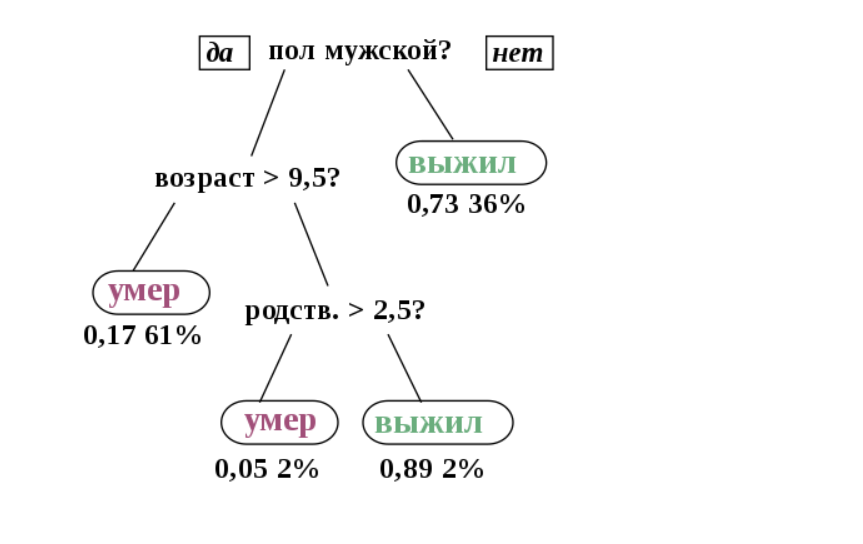

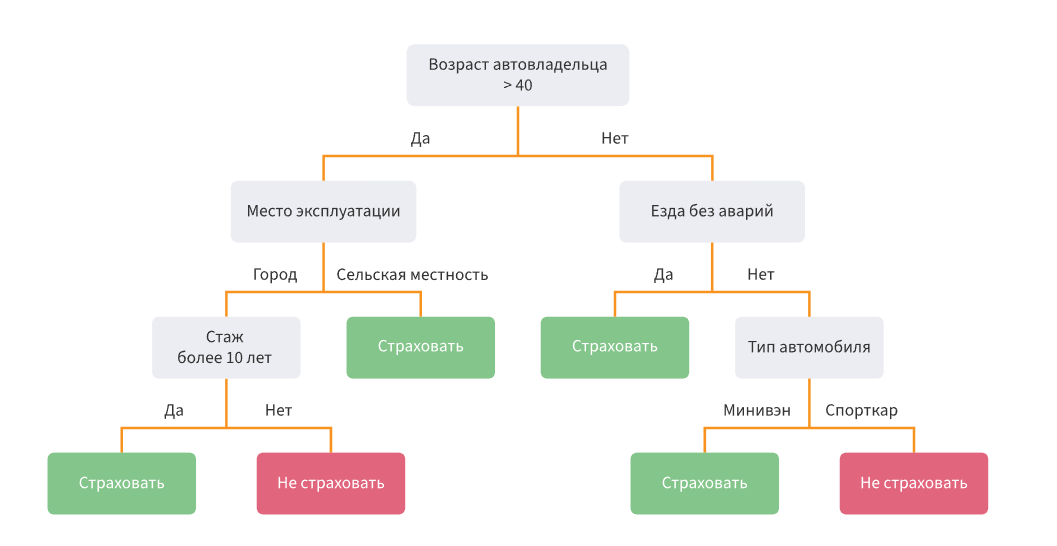

Основные этапы построения дерева
* Определите «лучший признак » в наборе данных для их разбиения. О том, как определить этот «лучший признак » поговорим позже.
* Разбейте данные на подмножества, которые будут содержать возможные значения для лучшего признака. Такое разбиение в основном определяет узел на дереве, то есть каждый узел — это разделенная точка, основанная на определенном признаке из наших данных.
* Рекурсивно сгенерируйте новые узлы дерева с помощью подмножества данных, созданных на 2 этапе. Продолжайте разбиение до тех пор, пока не достигните точки, на которой будет находится оптимизированная каким-то способом максимальная точность. Старайтесь минимизировать количество разбиений и узлов.

In [6]:
#объвляем модель
clf_tree = tree.DecisionTreeClassifier(max_depth=3)

Команда fit обучает нашу модель на наборе данных. Два главных аргумента:
* Х - набор признаков
* у - результирующая переменная

In [7]:
#обучаем модель
clf_tree = clf_tree.fit(X[['Sex','Fare','Age','SibSp','Parch']],Y)

In [8]:
#для отрисовки дерева
import graphviz
dot_data = tree.export_graphviz(clf_tree, out_file=None,
                     feature_names=X[['Sex','Fare','Age','SibSp','Parch']].columns,
                     class_names=['died','survived'],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("titanic")

'titanic.pdf'

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [10]:
# разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

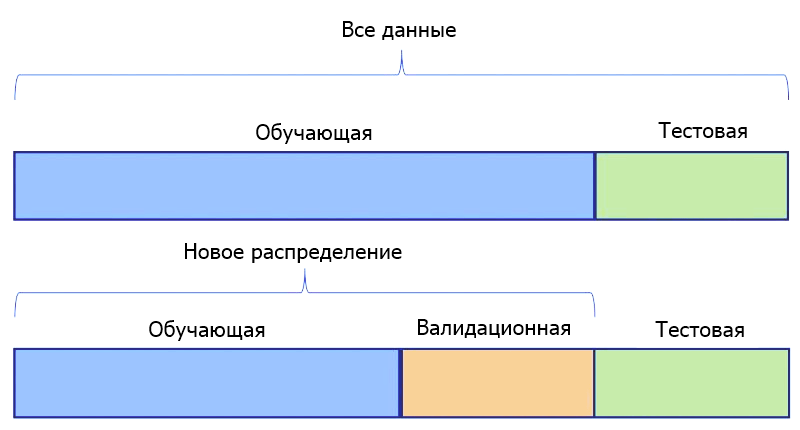

In [11]:
clf_tree2 = tree.DecisionTreeClassifier(max_depth=3)
clf_tree2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

Второй важный метод - predict: позволяет осуществлять прогноз с помощью обученной ранее модели. Из аргументов - набор признаков для прогнозирования!

In [12]:
y_pred = clf_tree2.predict(X_test)

In [13]:
y_pred

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
X_test.shape

(215, 11)

In [ ]:
y_pred.shape

(215,)

Измерим точность нашей модели - долю правильных ответов

accuracy.svg

In [ ]:
accuracy = accuracy_score(y_test,y_pred)
print('Точность на тестовой выборке:',round(accuracy,3))

Точность на тестовой выборке: 0.777


Больше про метрики в регрессии и классификации в папке intro

## Деревья решений в регрессии

In [ ]:
#делим на X и Y
Y = titanic_df['Fare']
X = titanic_df.drop(['Fare'],axis=1)

In [ ]:
regr_tree = tree.DecisionTreeRegressor()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
regr_tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
dot_data = tree.export_graphviz(regr_tree, out_file=None,
                     feature_names=X.columns,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("titanic")

'titanic.pdf'

In [ ]:
y_pred = regr_tree.predict(X_test)
y_pred

array([ 17.33333333,  26.        ,  26.        ,  59.4021    ,
         7.95416667,  23.        ,   8.6625    ,  34.375     ,
         7.775     ,  10.1771    ,  86.5       ,  13.        ,
        66.6       ,   7.05      , 135.6333    ,  73.5       ,
         7.2292    ,  39.4       ,  19.5       ,  78.2667    ,
        46.9       ,  19.5       ,   7.2292    ,  26.55      ,
         7.69443333,   7.9125    ,   7.9125    ,  65.        ,
         7.2292    ,   7.05      ,   9.825     ,  27.9       ,
        26.2875    ,   8.05      ,  14.1083    ,  15.55      ,
        21.        ,  79.2       ,  32.3208    ,   7.5521    ,
        14.5       ,   8.4975    , 120.        ,  26.        ,
        71.        ,  12.825     ,  26.25      ,  18.75      ,
         0.        ,  76.7292    ,  90.        ,  11.75      ,
        66.6       ,   8.6625    ,   7.31666667,  13.5       ,
        50.4958    ,  31.3875    ,  16.1       ,  13.5       ,
       146.5208    ,   7.7333    ,  26.25      ,   7.91

In [ ]:
from sklearn.metrics import mean_squared_error

Рассчитаем MSE для тестовой выборки

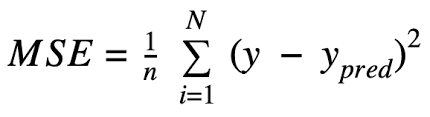

In [ ]:
mse = mean_squared_error(y_pred,y_test)
print("MSE:",mse)

MSE: 5442.18359384586


## Задания

1. Обучите модель классификации с использование DT на признаках Пол, Стоимость билета и Класс пассажира для прогнозирования выживаемости пассажиров

2. Обучите вторую модель. По сравнению с 1 моделью добавьте к признакам Возраст, SibSp и Parch.

3. При одинаковом разбиение на обучающую и тестовую выборки при какой модели точность будет выше?